In [1]:
# Cell 0: Install Required Libraries
!pip install opencv-python-headless
!pip install scikit-learn
!pip install matplotlib
!pip install scikit-image

In [2]:
# Cell 1: Import Libraries
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import entropy
from skimage.filters import sobel


In [4]:
# Cell 2: Load Video
video_path = '/content/video.mp4'  # Replace with your video path
cap = cv2.VideoCapture(video_path)

frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)
cap.release()

print(f"Total Frames: {len(frames)}")

Total Frames: 1877


In [5]:
# Cell 3: Scene Segmentation (Modified to Capture More Frames)
def calculate_histogram(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    return cv2.normalize(hist, hist).flatten()

threshold = 0.2  # Lower threshold for more sensitivity
selected_frames = [frames[0]]
last_hist = calculate_histogram(frames[0])

for i in range(1, len(frames)):
    current_hist = calculate_histogram(frames[i])
    diff = cv2.compareHist(last_hist, current_hist, cv2.HISTCMP_CORREL)
    if diff < (1 - threshold):
        selected_frames.append(frames[i])
        last_hist = current_hist

if len(selected_frames) < 30:
    step = max(1, len(frames) // 30)
    selected_frames = [frames[i] for i in range(0, len(frames), step)]

print(f"Frames after Scene Segmentation: {len(selected_frames)}")

Frames after Scene Segmentation: 70


In [6]:
# Cell 4: Optical Flow Analysis
def calculate_optical_flow(prev_frame, next_frame):
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    magnitude, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    return np.mean(magnitude)

dynamic_frames = [selected_frames[0]]
for i in range(1, len(selected_frames)):
    motion = calculate_optical_flow(selected_frames[i-1], selected_frames[i])
    if motion > 2.5:  # Adjust threshold as necessary
        dynamic_frames.append(selected_frames[i])

print(f"Frames after Optical Flow Analysis: {len(dynamic_frames)}")


Frames after Optical Flow Analysis: 64


In [7]:
# Cell 5: K-Means Clustering
def extract_features(frames):
    features = []
    for frame in frames:
        features.append(calculate_histogram(frame))
    return np.array(features)

features = extract_features(dynamic_frames)
n_clusters = min(25, len(dynamic_frames))  # Adjust number of clusters per scene
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(features)
clustered_frames = []

for cluster in range(n_clusters):
    indices = np.where(kmeans.labels_ == cluster)[0]
    clustered_frames.append(dynamic_frames[indices[0]])

print(f"Frames after K-Means Clustering: {len(clustered_frames)}")


Frames after K-Means Clustering: 25


In [8]:
# Cell 6: Select Informative Frames
def calculate_entropy(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    hist, _ = np.histogram(gray, bins=256, range=(0, 256), density=True)
    return entropy(hist)

informative_frames = sorted(clustered_frames, key=calculate_entropy, reverse=True)[:20]

print(f"Final Selected Frames: {len(informative_frames)}")


Final Selected Frames: 20


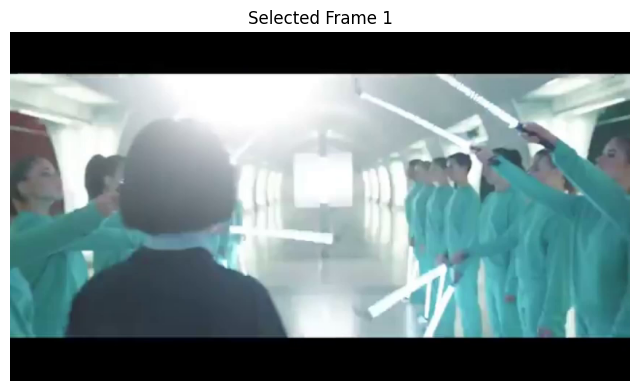

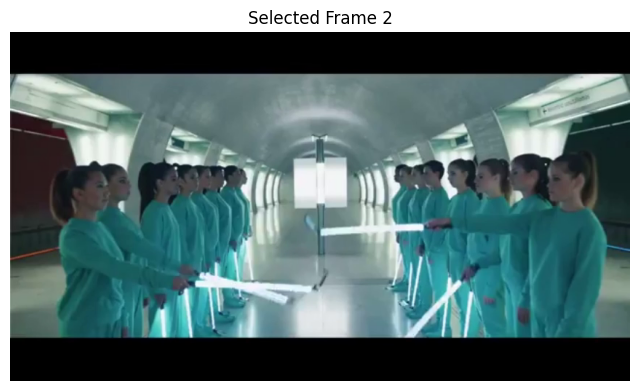

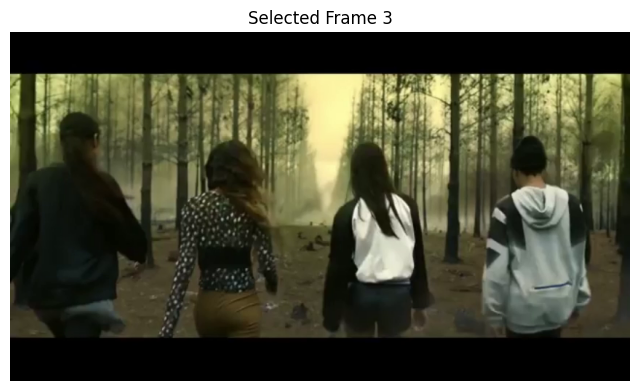

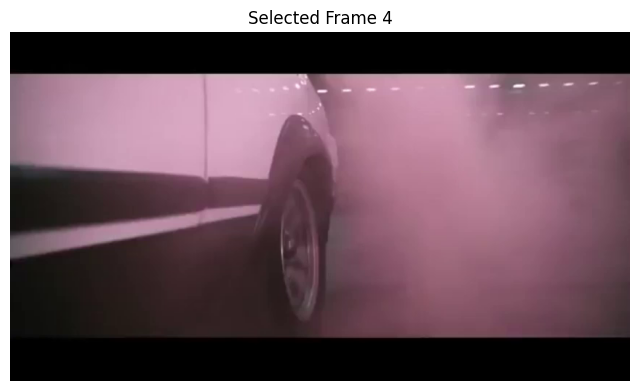

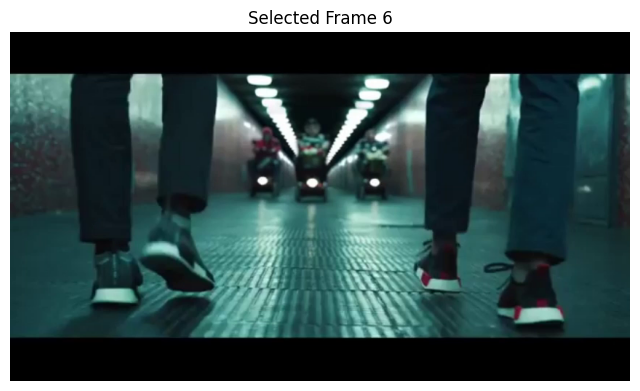

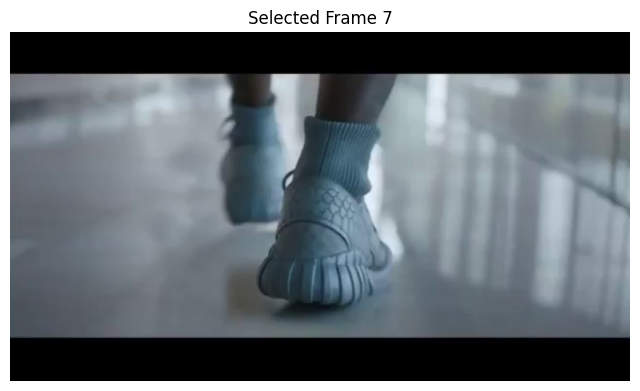

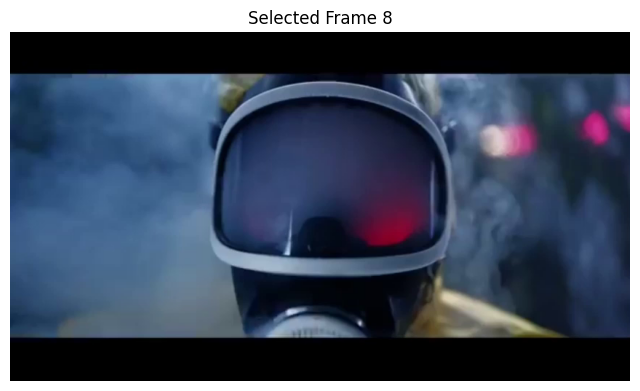

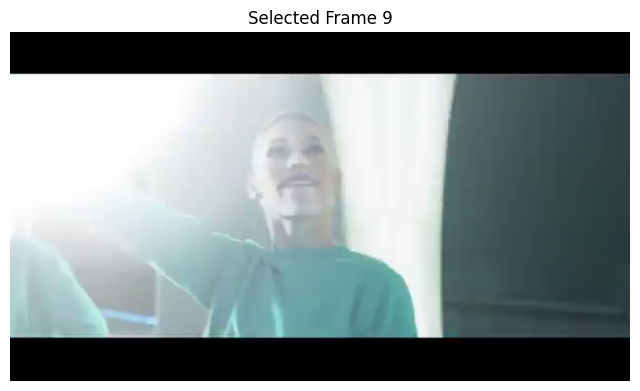

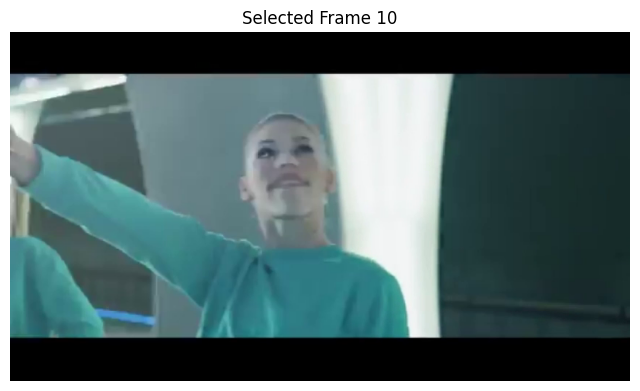

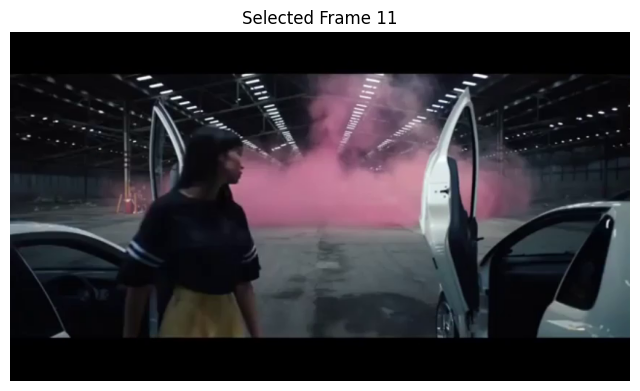

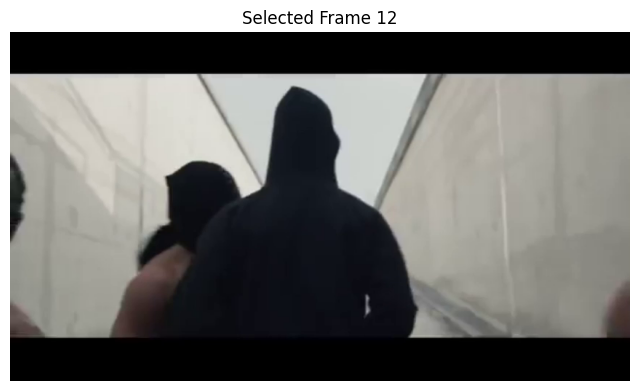

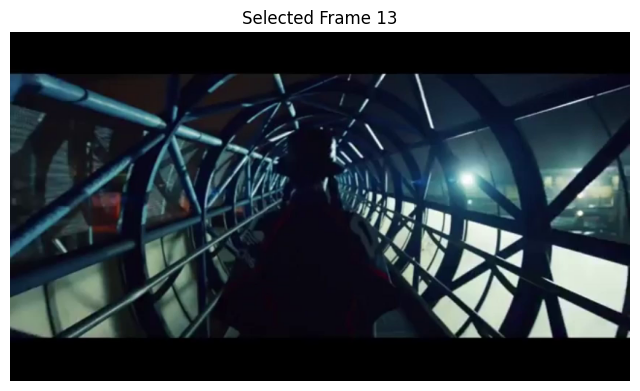

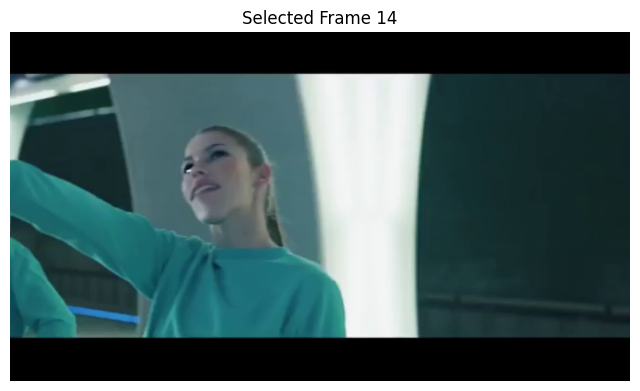

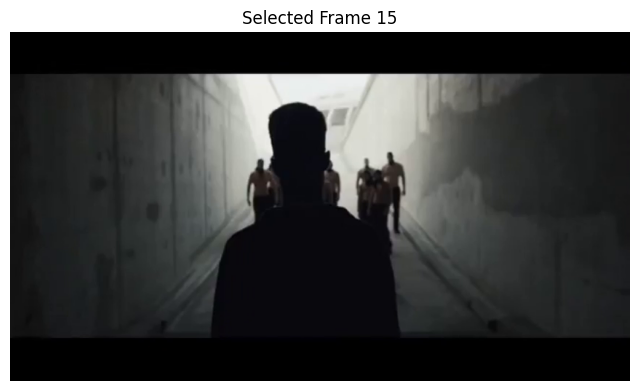

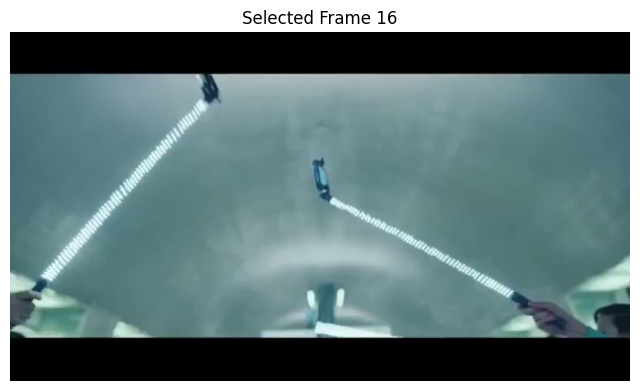

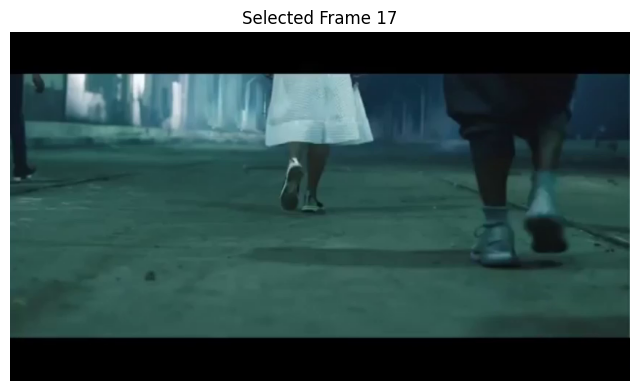

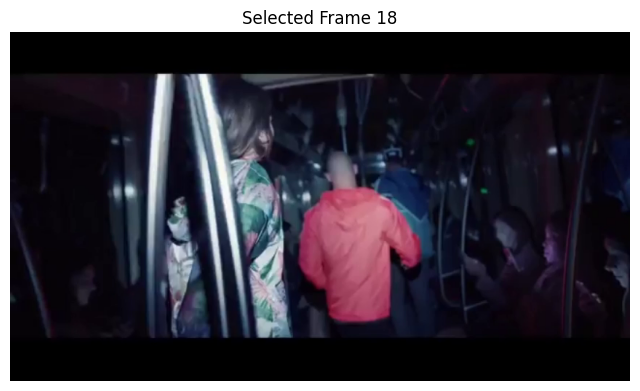

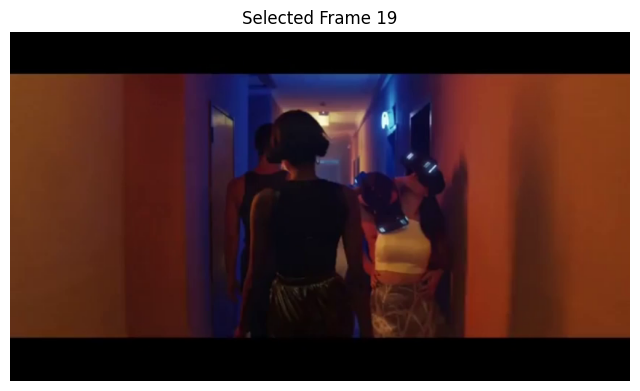

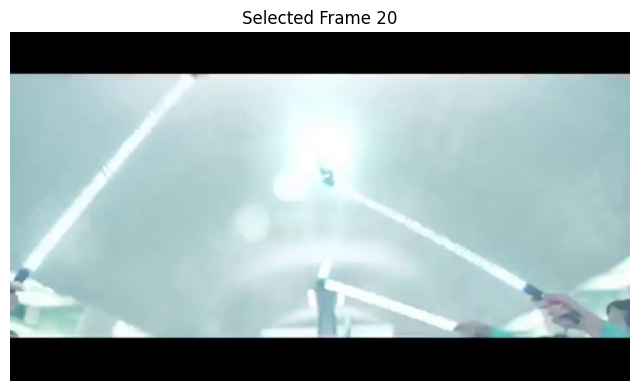

In [9]:
# Cell 7: Display and Save Frames
for i, frame in enumerate(informative_frames):
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Selected Frame {i+1}")
    plt.show()

In [40]:
!wget -O MobileNetSSD_deploy.prototxt https://github.com/chuanqi305/MobileNet-SSD/raw/master/MobileNetSSD_deploy.prototxt
!wget -O MobileNetSSD_deploy.caffemodel https://github.com/chuanqi305/MobileNet-SSD/raw/master/MobileNetSSD_deploy.caffemodel


--2024-11-09 17:27:47--  https://github.com/chuanqi305/MobileNet-SSD/raw/master/MobileNetSSD_deploy.prototxt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-11-09 17:27:47 ERROR 404: Not Found.

--2024-11-09 17:27:47--  https://github.com/chuanqi305/MobileNet-SSD/raw/master/MobileNetSSD_deploy.caffemodel
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-11-09 17:27:47 ERROR 404: Not Found.



In [10]:
!ls -lh MobileNetSSD_deploy.*

-rw-r--r-- 1 root root 23M Nov 10 05:20 MobileNetSSD_deploy.caffemodel
-rw-r--r-- 1 root root 29K Nov 10 05:20 MobileNetSSD_deploy.prototxt


In [26]:
# Cell X: Load Pre-trained MobileNet SSD Model (Run this before Cell 9)
net = cv2.dnn_DetectionModel('/content/MobileNetSSD_deploy.prototxt',
                             '/content/MobileNetSSD_deploy.caffemodel')
net.setInputSize(320, 320)
net.setInputScale(1.0 / 127.5)
net.setInputMean((127.5, 127.5, 127.5))
net.setInputSwapRB(True)


< cv2.dnn.Model 0x79469d7c8150>

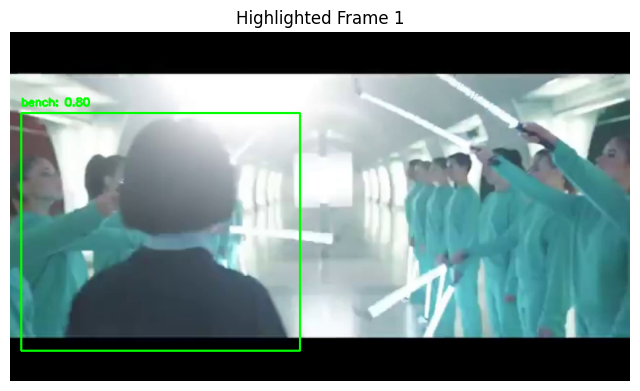

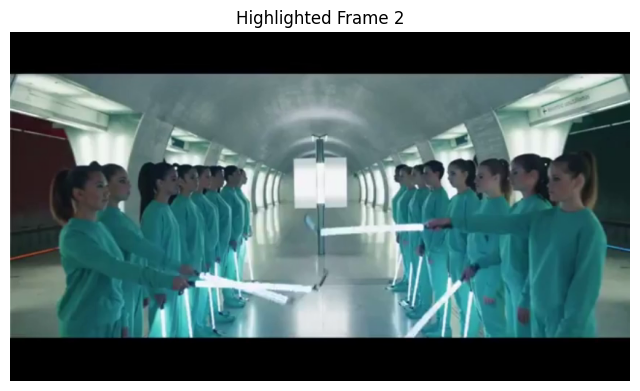

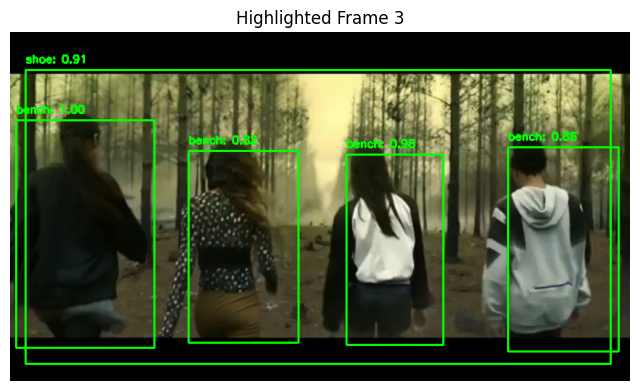

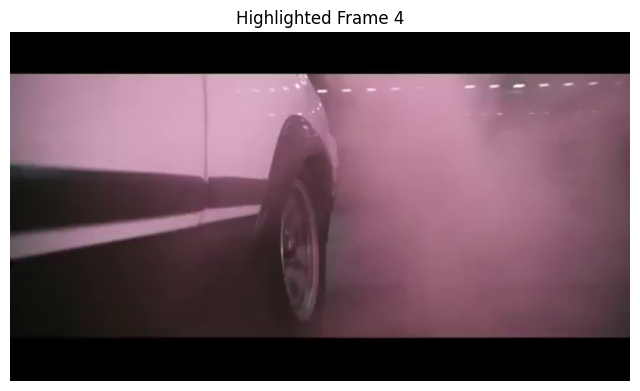

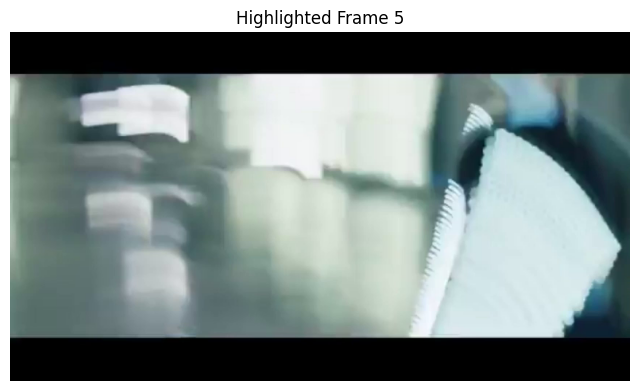

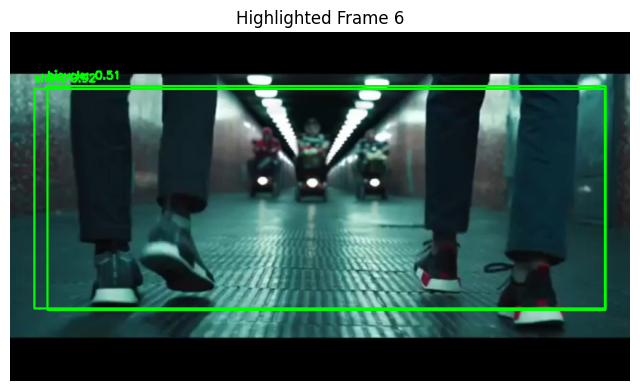

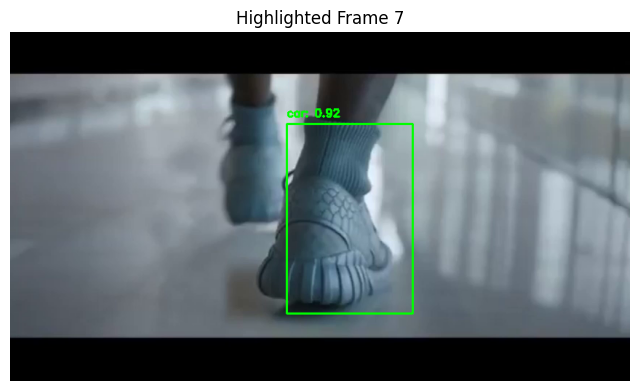

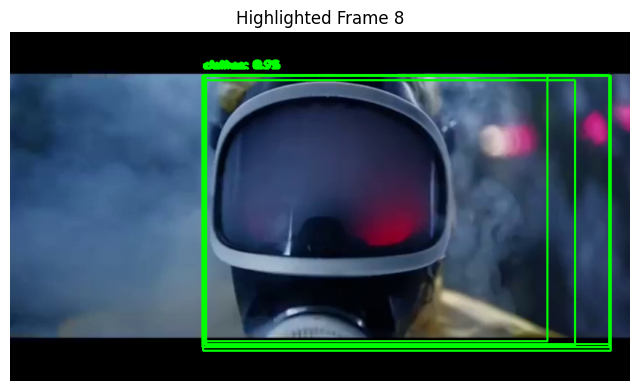

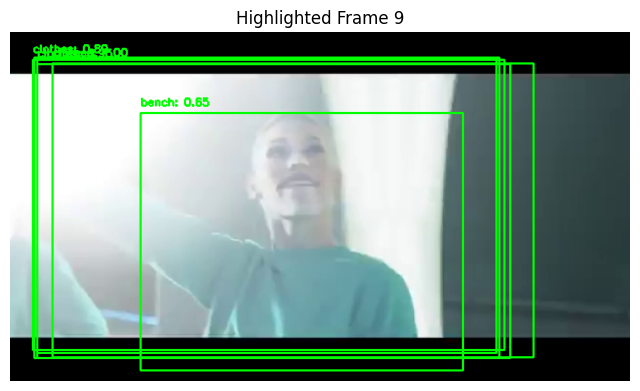

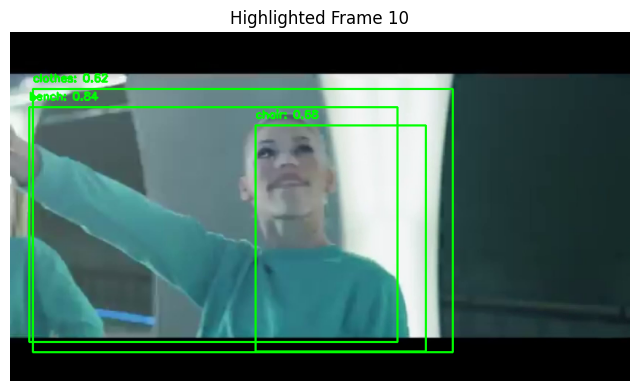

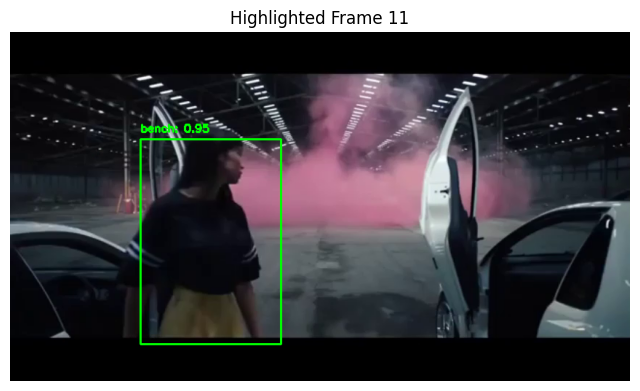

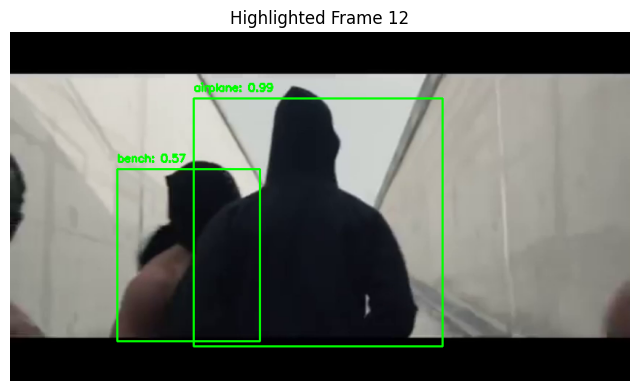

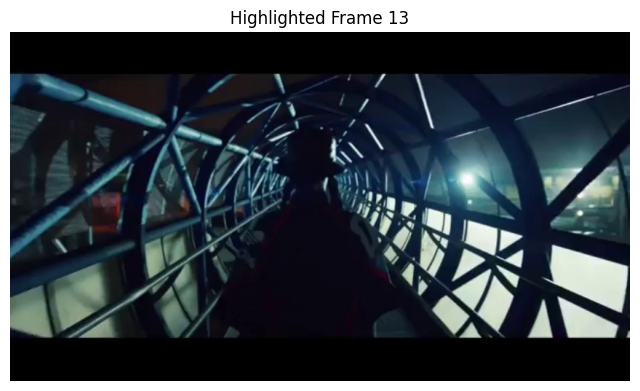

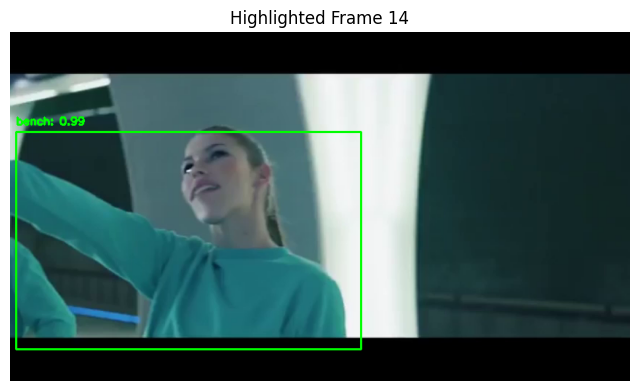

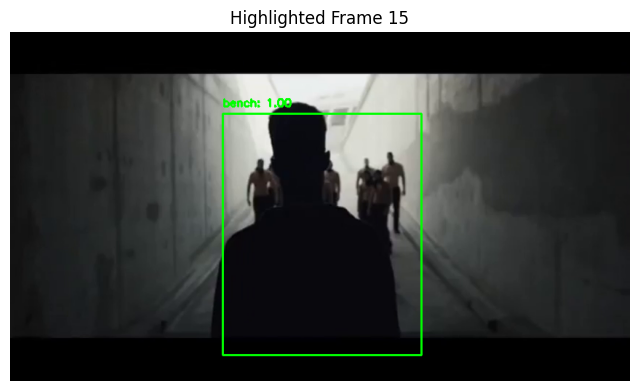

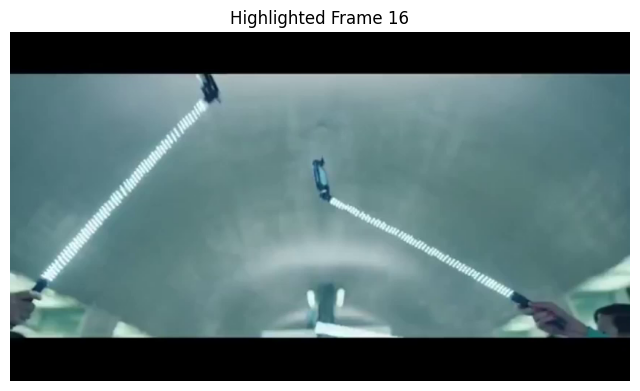

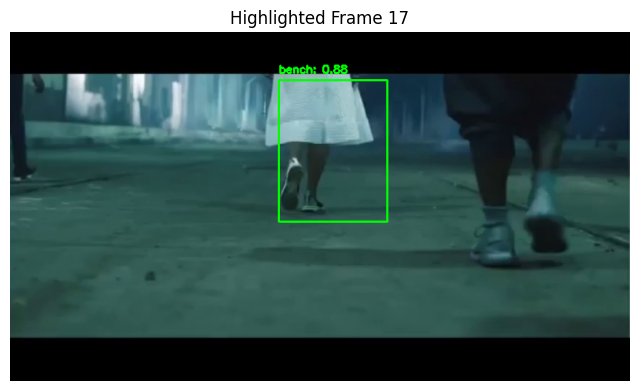

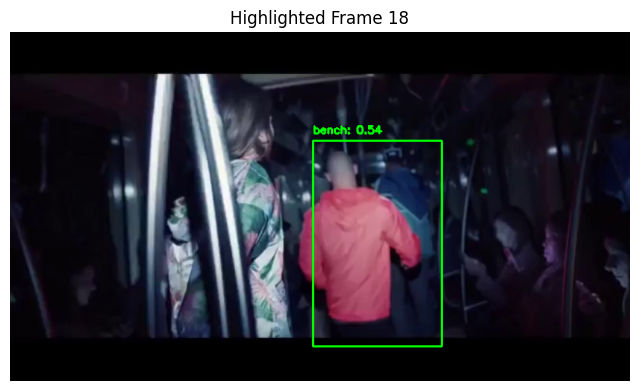

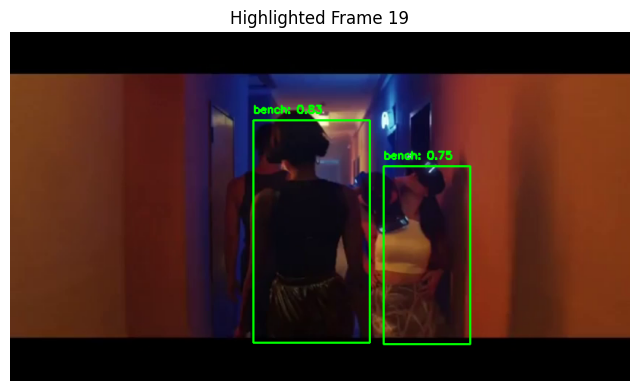

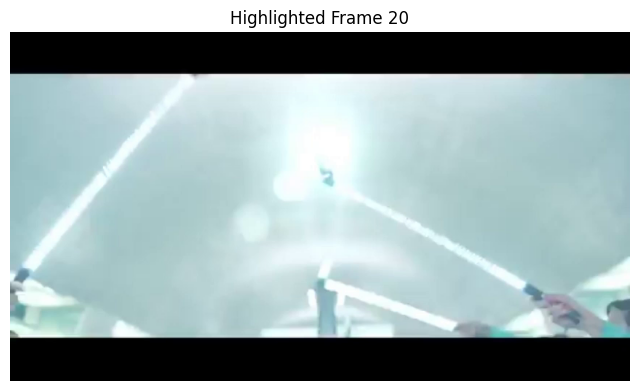

In [29]:
classes = {16: 'backpack', 17: 'umbrella', 18: 'bag', 19: 'shoe', 20: 'clothes'}
# Cell 9: Detect and Highlight Shoppable Items in the Final Frames
for i, frame in enumerate(informative_frames):  # Assume informative_frames contains your 20 selected frames
    # Detect objects in the frame
    class_ids, confidences, boxes = net.detect(frame, confThreshold=0.5)

    # Iterate over the detected objects
    if len(class_ids) > 0:  # Check if any objects were detected
        for class_id, confidence, box in zip(class_ids.flatten(), confidences.flatten(), boxes):
            if class_id in classes:
                label = f"{classes[class_id]}: {confidence:.2f}"
                cv2.rectangle(frame, box, color=(0, 255, 0), thickness=2)
                cv2.putText(frame, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Highlighted Frame {i+1}")
    plt.show()